<a href="https://colab.research.google.com/github/jaguara01/20231215_CaseStudy_ML_Neural_Network/blob/main/20231215_CaseStudy_ML_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case study Machine learning**

AB Gaming is a digital gaming platform that offers a wide variety of games available
under monthly subscriptions. There are 3 different plans, labeled SMALL, MEDIUM and
LARGE, and can be paid in USD or EUR.
You are provided with 2 datasets:
- sales.csv: contains the sales of clients acquired since 2019-01-01. Data was
extracted on 2020-12-31. This dataset includes a unique identifier for each user
(account_id).
- user_activity.csv: this dataset contains the following user characteristics as well
as their unique identifier (same as in sales.csv):
	- gender: gender of user reported in their profile.
	-  age: age in completed years of the user at the beginning of their subscription.
	- type: device type the user has installed the gaming platform.
	- genre1: most played game genre by the user.
	- genre2: second most played game genre by the user.
	- hours: mean number of hours played by the user weekly.
	- games: median number of different games played by the user weekly

Create a ML model to predict subscribers’ churn.

We define churn as the users that stop their subscription before their 6th renewal. Hence, a user that has less than 7 orders of payment is considered a churner. For this model we will be using activity for the first 3 months, so those users that have made only 1 or 2 payments should not be included in the model.

To create the model, extract relevant data (such as churner) from the sales.csv dataset and join it with the user_activity.csv dataset.

In the results of your report remember to answer these questions:

- What is the accuracy of your model? (consider also sensibility, specificity, PPV and
NPV)
- Do you consider it a good predictive model?

In the conclusion/discussion of your report make sure to mention any limitations as well as
ways to enhance future iterations of the creation of the model.

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from tensorflow import keras

# Import data

In [ ]:
df_sales = pd.read_csv('/content/drive/MyDrive/XXX/sales.csv')
df_activity = pd.read_csv('/content/drive/MyDrive/XXX/user_activity.csv')

In [ ]:
df_activity.head()

,account_id,gender,genre1,genre2,type,games,age,hours
0,101530,male,role-playing,action,mobile,8,21,7.573853
1,731892,female,adventure,action,computer,9,25,4.620231
2,856432,male,action,role-playing,mobile,19,35,13.608988
3,1425820,male,adventure,adventure,mobile,8,20,8.648719
4,1881252,male,action,strategy,computer,6,18,8.929738


In [ ]:
df_sales.head()

,order_id,account_id,start_date,plan,amount,currency
0,C5G1ckzVUC1V,36369294,2019-03-17,MEDIUM,12.95,EUR
1,LyPKxILXvkiu,36369294,2019-04-17,MEDIUM,12.95,EUR
2,729R0C9dVx49,36369294,2019-05-17,MEDIUM,12.95,EUR
3,RrxBXQYG9Qn8,13708705,2020-08-28,SMALL,8.95,EUR
4,iYemtey2MjLT,940537915,2020-07-17,SMALL,8.95,EUR


# Churn identification

In [ ]:
# A user that has less than 7 orders of payment is considered a churner
df_sales_seq = df_sales.groupby(["account_id", "plan", "currency"])["order_id"].count().reset_index(name="seq")
df_sales_seq["is_churn"]=np.where(df_sales_seq["seq"] < 7,1,0)

# For each accound_id, we want to know last transaction
#df_sales_init = df_sales.groupby(["account_id"])["start_date"].min().reset_index(name="start_date")
df_sales_last = df_sales.groupby(["account_id"])["start_date"].max().reset_index(name="last_date")



In [ ]:
df_users = pd.merge(df_sales_last, df_sales_seq, on='account_id')

In [ ]:
df_users.head()

,account_id,last_date,plan,currency,seq,is_churn
0,101530,2019-12-03,SMALL,EUR,4,1
1,731892,2020-10-12,SMALL,EUR,9,0
2,856432,2020-10-25,SMALL,EUR,10,0
3,1425820,2019-07-25,SMALL,EUR,2,1
4,1881252,2019-12-22,SMALL,USD,1,1


In [ ]:
df_users.is_churn.value_counts()

1    1157
0     843
Name: is_churn, dtype: int64

Number of users with less than 2 payments and who will be rejected by the model

In [ ]:
df_users[(df_users["seq"] <= 2)].is_churn.value_counts()

1    698
Name: is_churn, dtype: int64

Some accounts shouldn't be taken into account
  - Users that have made only 1 or 2 payments
  - Users seen as churn at the end of the data collection. Those users may or may not continue their plan after the last month (2020/12 (USD) and 2020/10 (EUR))

In [ ]:
user_reject = df_users[((df_users["last_date"]>"2020-11-30") & (df_users["is_churn"] == 1) & (df_users["currency"] == "USD"))
                    | ((df_users["last_date"]>"2020-09-31") & (df_users["is_churn"] == 1) & (df_users["currency"] == "EUR"))
                    | (df_users["seq"] <= 2)]

In [ ]:
#List of all the users that don't need to be taken into accout in the model
user_reject_list = user_reject.account_id.values.tolist()
df_users_filtered = df_users[~df_users['account_id'].isin(user_reject_list)]

In [ ]:
df_input = pd.merge(df_activity,df_users_filtered.drop(['last_date','seq'], axis=1),how="inner", on="account_id")

df_input.head()


,account_id,gender,genre1,genre2,type,games,age,hours,plan,currency,is_churn
0,101530,male,role-playing,action,mobile,8,21,7.573853,SMALL,EUR,1
1,731892,female,adventure,action,computer,9,25,4.620231,SMALL,EUR,0
2,856432,male,action,role-playing,mobile,19,35,13.608988,SMALL,EUR,0
3,2397506,male,adventure,role-playing,computer,13,32,7.151723,SMALL,USD,0
4,2436396,male,adventure,sports,mobile,10,25,14.455147,MEDIUM,USD,0


## Inbalance

0    843
1    225
Name: is_churn, dtype: int64


([<matplotlib.patches.Wedge at 0x7914ece0d090>,
 [Text(-0.8677406433221845, 0.6760371113532169, '0'),
  Text(0.8677406116746018, -0.6760371519750877, '1')],
 [Text(-0.4733130781757369, 0.3687475152835728, '78.93%'),
  Text(0.4733130609134191, -0.36874753744095695, '21.07%')])

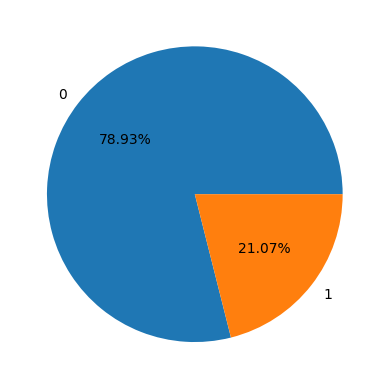

In [ ]:
print(df_input.is_churn.value_counts())
plt.pie(df_input['is_churn'].value_counts().values, labels=df_input['is_churn'].value_counts().index, autopct='%1.2f%%')

We notice that in the input, we have a inbalance between churn and non churn. This can be solve by oversampling in the model training.

# Exercice 2 - Machine learning

## Data preparation

Categorical variables conversion to dummies - One hot encoding

In [ ]:
df_input_dum = pd.get_dummies(data=df_input, columns=['gender','genre1','genre2','type','plan','currency'])
df_input_dum.columns

Index(['account_id', 'games', 'age', 'hours', 'is_churn', 'gender_female',
       'gender_male', 'genre1_action', 'genre1_adventure',
       'genre1_role-playing', 'genre1_simulation', 'genre1_sports',
       'genre1_strategy', 'genre2_action', 'genre2_adventure',
       'genre2_role-playing', 'genre2_simulation', 'genre2_sports',
       'genre2_strategy', 'type_computer', 'type_mobile', 'type_tablet',
       'plan_LARGE', 'plan_MEDIUM', 'plan_SMALL', 'currency_EUR',
       'currency_USD'],
      dtype='object')

In [ ]:
df_input_dum.head()

,account_id,games,age,hours,is_churn,gender_female,gender_male,genre1_action,genre1_adventure,genre1_role-playing,...,genre2_sports,genre2_strategy,type_computer,type_mobile,type_tablet,plan_LARGE,plan_MEDIUM,plan_SMALL,currency_EUR,currency_USD
0,101530,8,21,7.573853,1,0,1,0,0,1,...,0,0,0,1,0,0,0,1,1,0
1,731892,9,25,4.620231,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
2,856432,19,35,13.608988,0,0,1,1,0,0,...,0,0,0,1,0,0,0,1,1,0
3,2397506,13,32,7.151723,0,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,1
4,2436396,10,25,14.455147,0,0,1,0,1,0,...,1,0,0,1,0,0,1,0,0,1


We split the available data into 2 data sets: Training (80%) and Testing (20%)

In [ ]:
training, testing = np.split(df_input_dum.sample(frac=1), [int(0.8*len(df_input_dum))])

Standardization of the input

In [ ]:
def scale_dataset(dataframe, oversample=False):
  X = dataframe.drop(['is_churn','account_id'],axis='columns').values
  y = dataframe['is_churn'].values

# Before doing any learning, all variable should be scaled
  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [ ]:
train, X_train, y_train = scale_dataset(training, oversample=True)
test, X_test, y_test = scale_dataset(testing, oversample=False)


## Neural Network

In [ ]:
m,n  = X_train.shape

model = keras.Sequential([
    keras.layers.Dense(n, input_shape=(n,), activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') #adapted for binomial output
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
42/42 [==============================] - 4s 9ms/step - loss: 0.7100 - accuracy: 0.5337
Epoch 2/100
42/42 [==============================] - 0s 10ms/step - loss: 0.6202 - accuracy: 0.6552
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 0.5641 - accuracy: 0.7211
Epoch 4/100
42/42 [==============================] - 0s 8ms/step - loss: 0.5207 - accuracy: 0.7789
Epoch 5/100
42/42 [==============================] - 0s 7ms/step - loss: 0.4880 - accuracy: 0.7856
Epoch 6/100
42/42 [==============================] - 0s 7ms/step - loss: 0.4646 - accuracy: 0.8028
Epoch 7/100
42/42 [==============================] - 0s 7ms/step - loss: 0.4472 - accuracy: 0.8096
Epoch 8/100
42/42 [==============================] - 0s 8ms/step - loss: 0.4329 - accuracy: 0.8141
Epoch 9/100
42/42 [==============================] - 0s 5ms/step - loss: 0.4228 - accuracy: 0.8193
Epoch 10/100
42/42 [==============================] - 0s 6ms/step - loss: 0.4119 - accuracy: 0.8291
Epoch 11

### Tests and report

In [ ]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.5201 - accuracy: 0.7991


[0.5201286673545837, 0.7990654110908508]

In [ ]:
yp = model.predict(X_test)
# interpretation
y_pred = []
for element in yp:
    if element > 0.5: #probability of the sigmoid
        y_pred.append(1)
    else:
        y_pred.append(0)

7/7 [==============================] - 0s 2ms/step


#### Accuracy

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       176
           1       0.45      0.61      0.52        38

    accuracy                           0.80       214
   macro avg       0.68      0.72      0.70       214
weighted avg       0.83      0.80      0.81       214



Confusion Matrix

Text(95.72222222222221, 0.5, 'Truth')

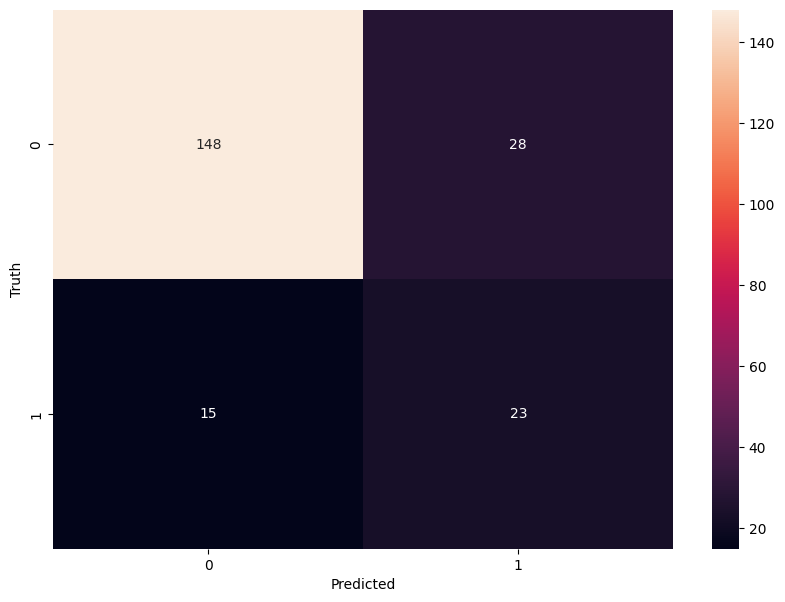

In [ ]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### Sensibility, specificity, PPV and NPV

In [ ]:
# Generate confusion matrix
# True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Sensitivity, recall, hit rate, or true positive rate (TPR)
# Proportion of actual positives correctly identified.
sensitivity = tp / (tp + fn)

# Specificity, selectivity or true negative rate (TNR)
# Proportion of actual negatives correctly identified.
specificity = tn / (tn + fp)

# Positive Predictive Value (PPV) or Precision
# Proportion of positive identifications that were actually correct
ppv = tp / (tp + fp)

# Negative Predictive Value (NPV)
# Proportion of negative identifications that were actually correct.
npv = tn / (tn + fn)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"PPV: {ppv}")
print(f"NPV: {npv}")

Sensitivity: 0.6052631578947368
Specificity: 0.8409090909090909
PPV: 0.45098039215686275
NPV: 0.9079754601226994


## Conclusion

The current model give us an accuracy of around 97% and with a small proportion of false positive and false negative. We can conclude that this is a good predictive model.

97% is actually very high but it doesn't seem that we have any data leak.
Also, we saw earlier a big inbalance between churn and non churn in the model input (20% churn and 80% non churn). A model putting only 'non churn' value may have already a high accuracy.



# Exercice 3 - Prediction

## Input data for prediction

We select only those users from the original dataset whose future as churners is uncertain

In [ ]:
user_pred = df_users[(((df_users["last_date"]>"2020-11-30") & (df_users["is_churn"] == 1) & (df_users["currency"] == "USD"))
                    | ((df_users["last_date"]>"2020-09-31") & (df_users["is_churn"] == 1) & (df_users["currency"] == "EUR")) )
                    & (df_users["seq"] > 2)]

user_pred.head()

,account_id,last_date,plan,currency,seq,is_churn
15,7213516,2020-12-09,SMALL,USD,6,1
16,7320093,2020-10-24,SMALL,EUR,3,1
24,11173043,2020-12-12,SMALL,USD,3,1
30,15316204,2020-12-11,SMALL,USD,6,1
34,18261049,2020-10-18,SMALL,EUR,5,1


In [ ]:
user_pred_list = user_pred.account_id.values.tolist()

Input data set to be used by the prediction model

In [ ]:
df_pred_input_acc = pd.merge(df_activity,df_users[df_users['account_id'].isin(user_pred_list)].drop(['is_churn'], axis=1),how="inner", on="account_id")
df_pred_input = df_pred_input_acc.drop(['last_date','seq'], axis=1)

df_pred_input_acc.head()

,account_id,gender,genre1,genre2,type,games,age,hours,last_date,plan,currency,seq
0,7213516,female,adventure,adventure,computer,8,24,8.944547,2020-12-09,SMALL,USD,6
1,7320093,male,adventure,strategy,tablet,5,23,12.182189,2020-10-24,SMALL,EUR,3
2,11173043,female,adventure,adventure,mobile,16,31,7.838690,2020-12-12,SMALL,USD,3
3,15316204,male,sports,adventure,mobile,16,32,11.416764,2020-12-11,SMALL,USD,6
4,18261049,female,adventure,adventure,mobile,13,26,12.313872,2020-10-18,SMALL,EUR,5


Function to evaluate users who may be churned or not

In [ ]:
def churn_pred(df_pred_input):
    df_input_dum = pd.get_dummies(data=df_pred_input.drop(['account_id'], axis=1), columns=['gender','genre1','genre2','type','plan','currency'])
    input_value = df_input_dum.values

    scaler = StandardScaler()
    X_input = scaler.fit_transform(input_value)

    yp = model.predict(X_input)

    y_pred = []
    for element in yp:
        if element > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)

    df_pred_output = df_pred_input.copy()
    df_pred_output['is_churn_pred'] = y_pred

    return df_pred_output

In [ ]:
Prediction = churn_pred(df_pred_input)

8/8 [==============================] - 0s 4ms/step


## Prediction output

In [ ]:
Prediction.head(20)

,account_id,gender,genre1,genre2,type,games,age,hours,plan,currency,is_churn_pred
0,7213516,female,adventure,adventure,computer,8,24,8.944547,SMALL,USD,0
1,7320093,male,adventure,strategy,tablet,5,23,12.182189,SMALL,EUR,0
2,11173043,female,adventure,adventure,mobile,16,31,7.838690,SMALL,USD,1
3,15316204,male,sports,adventure,mobile,16,32,11.416764,SMALL,USD,0
4,18261049,female,adventure,adventure,mobile,13,26,12.313872,SMALL,EUR,0
5,19155603,female,role-playing,adventure,mobile,3,28,8.876661,SMALL,EUR,1
6,23695119,male,role-playing,role-playing,computer,9,23,12.470576,SMALL,EUR,0
7,26855100,female,simulation,sports,computer,11,42,5.008969,SMALL,EUR,0
8,27664236,male,adventure,role-playing,mobile,22,33,22.162721,SMALL,EUR,0
9,30398911,female,simulation,strategy,computer,10,23,9.460995,LARGE,EUR,1
